# Different storage backends - using numpy/scipy and petsc4py [(Notebook)][1]

[1]: _downloads/laplace-la.ipynb

For the first example we used solvers available in dune-fem - simple Krylov solvers with only diagonal preconditioning. Changing the `storage` argument in the construction of the space makes it possible to use more sophisticated solvers (either better preconditioners or direct solvers). For example
~~~
spc = create.space("lagrange", grid, dimrange=1, order=1, storage="istl")
~~~
in the above code will switch to the solvers from `dune-istl`, other options are for example `eigen` or `petsc`.

Using the internal `fem` storage structure or the `eigen` matrix/vector strorage
it is also possible to directly treate them as`numpy` vectors and an assembled system matrix can be stored in a `sympy` sparse matrix.

__Note__: to use `eigen` matrices the `Eigen` package must be available and `dune-py` must have been configured with `Eigen`.

Since we will be implementing a Newton solver first, let's study a truelly non linear problem - a version of the p-Laplace problem:
\begin{gather}
  - \frac{d}{2}\nabla\cdot |\nabla u|^{p-2}\nabla u + u = f
\end{gather}

In [1]:
try:
    %matplotlib inline # can also use notebook or nbagg
except:
    pass
from dune.generator import builder
import math
import numpy as np
import scipy.sparse.linalg
import scipy.optimize     
import dune.grid
import dune.fem
from dune.fem.plotting import plotPointData as plot
import dune.create as create

from dune.ufl import Space
from ufl import TestFunction, TrialFunction, SpatialCoordinate, ds, dx, inner, grad

grid = create.grid("ALUConform", dune.grid.cartesianDomain([0, 0], [1, 1], [8, 8]), dimgrid=2)

spc = create.space("lagrange", grid, dimrange=1, order=1, storage='fem')

d = 0.001
p = 1.7

uflSpace = Space(spc)
u = TrialFunction(uflSpace)
v = TestFunction(uflSpace)
x = SpatialCoordinate(uflSpace.cell())

rhs = (x[0] + x[1]) * v[0]
a = (pow(d + inner(grad(u), grad(u)), (p-2)/2)*inner(grad(u), grad(v)) + inner(u, v)) * dx + 10*inner(u, v) * ds
b = rhs * dx + 10*rhs * ds
scheme = create.scheme("h1", spc, a==b,\
       parameters=\
       {"fem.solver.newton.linabstol": 1e-10,
        "fem.solver.newton.linreduction": 1e-10,
        "fem.solver.newton.verbose": 1,
        "fem.solver.newton.linear.verbose": 0})
# create a discrete solution over this space - will be initialized with zero by default

uh = create.function("discrete", spc, name="solution")

2018-06-10 18:41:25,916 - dune.common - INFO - MPI initialized successfully
2018-06-10 18:41:25,989 - dune.common.module - INFO - Using existing dune-py module in /home/dedner/Envs/dune3/.cache/dune-py
2018-06-10 18:41:25,992 - dune.generator.builder - INFO - using pre configured dune-py module
2018-06-10 18:41:26,332 - dune.create - INFO - Importing create registries from [ dune.femnv dune.functions dune.grid dune.fem dune.alugrid dune.vem ]
2018-06-10 18:41:26,333 - dune.generator.builder - INFO - Loading HierarchicalGrid
2018-06-10 18:41:26,465 - dune.generator.builder - INFO - Loading ReferenceElements
2018-06-10 18:41:26,579 - dune.generator.builder - INFO - Loading ReferenceElements
2018-06-10 18:41:26,693 - dune.generator.builder - INFO - Loading ReferenceElements
2018-06-10 18:41:26,812 - dune.generator.builder - INFO - Loading Space
2018-06-10 18:41:27,018 - dune.generator.builder - INFO - Loading ellipticModel
2018-06-10 18:41:27,154 - dune.generator.builder - INFO - Loading 

In the following we implement a simple Newton solver: given an initial guess $u^0$ (here taken to be zero) solve for $n\geq 0$:
\begin{align*}
   u^{n+1} = u^n - DS(u^n)(S(u^n)-g)
\end{align*}
Where $g$ is a discrete function containing the boundary values in the Dirichlet nodes and zero otherwise.

Let's first use the solve method on the scheme directly:

size: 128 newton iterations: 4


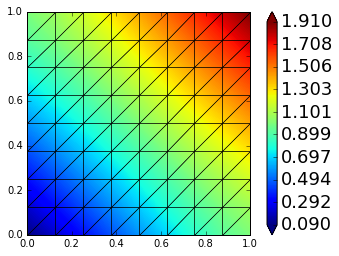

In [2]:
uh,info = scheme.solve(target = uh)
print("size:", grid.size(0), "newton iterations:", int(info['iterations']))
plot(uh)

Instead of `scheme.solve` we now use the call operator on the `scheme` (to compute $S(u^n$) as  well as `scheme.assemble` to get a copy of the system matrix in form of a scipy sparse row matrix. Note that this method is only available if the `storage` in the space is set `eigen`.

iterations (0) 8.204874174739299
iterations (1) 0.7706154521999535
iterations (2) 0.0056437449768389275
iterations (3) 2.3213588581879045e-06
iterations (4) 5.456246473161361e-13


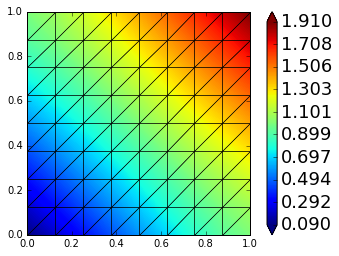

In [3]:
# Let's first clear the solution again
uh.clear()
# Need to auxiliary function
res = uh.copy() 

# Note: the following does not produce a copy of the dof
# vectors, but keep in mind that
# after grid adaptation the resulting numpy array
# will be invalid since the shared dof vector will have moved
# during its resizing - use copy=True to avoid this problem at
# the cost of a copy
sol_coeff = uh.as_numpy
res_coeff = res.as_numpy
n = 0

while True:
    scheme(uh, res)
    absF = math.sqrt( np.dot(res_coeff,res_coeff) )
    print("iterations ("+str(n)+")",absF)
    if absF < 1e-10:
        break
    matrix = scheme.assemble(uh)
    sol_coeff -= scipy.sparse.linalg.spsolve(matrix, res_coeff)
    n += 1

plot(uh)

We cam redo the above computation but now use the Newton solver available in sympy:

2018-06-10 18:41:28,648 - dune.generator.builder - INFO - Loading DiscreteFunction


0:  |F(x)| = 0.770615; step 1; tol 0.00793915
1:  |F(x)| = 0.00564374; step 1; tol 4.82727e-05
2:  |F(x)| = 2.32137e-06; step 1; tol 1.52264e-07
3:  |F(x)| = 5.57366e-13; step 1; tol 5.18841e-14


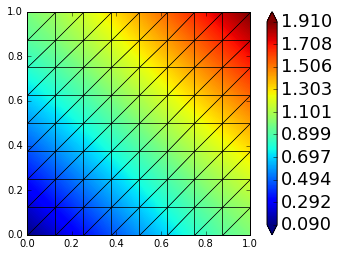

In [4]:
# let's first set the solution back to zero - since it already contains the right values
uh.clear()
def f(x_coeff):                     
    x = spc.numpyFunction(x_coeff, "tmp")
    scheme(x,res)         
    return res_coeff
# class for the derivative DS of S
class Df(scipy.sparse.linalg.LinearOperator):
    def __init__(self,x_coeff):
        self.shape = (sol_coeff.shape[0],sol_coeff.shape[0])
        self.dtype = sol_coeff.dtype
        # the following converts a given numpy array
        # into a discrete function over the given space
        x = spc.numpyFunction(x_coeff, "tmp")
        # store the assembled matrix
        self.jac = scheme.assemble(x)
    # reassemble the matrix DF(u) gmiven a dof vector for u
    def update(self,x_coeff,f): 
        x = spc.numpyFunction(x_coeff, "tmp")
        # Note: the following does produce a copy of the matrix
        # and each call here will reproduce the full matrix
        # structure - no reuse possible in this version
        self.jac = scheme.assemble(x)
    # compute DS(u)^{-1}x for a given dof vector x
    def _matvec(self,x_coeff):
        return scipy.sparse.linalg.spsolve(self.jac, x_coeff)

# call the newton krylov solver from scipy
sol_coeff[:] = scipy.optimize.newton_krylov(f, sol_coeff,
            verbose=1, f_tol=1e-8,
            inner_M=Df(sol_coeff))

plot(uh)

We can also use the package `petsc4py` to solve the problem.

__Note__: make sure that `dune` has been configured using the same version of `petsc` used for `petsc4py`

The first step is to change the storage in the space. Since also requires setting up the scheme and siscrete functions again to use the new storage structure.

We can directly use the `petsc` solvers by invoking `solve` on the scheme as before.

2018-06-10 18:42:03,587 - dune.generator.builder - INFO - Loading Scheme
2018-06-10 18:42:03,719 - dune.generator.builder - INFO - Loading DiscreteFunction


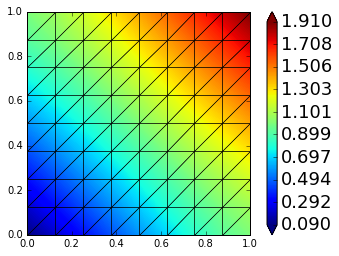

In [8]:
try:    
    import petsc4py, sys
    from petsc4py import PETSc
    petsc4py.init(sys.argv)
    spc = create.space("lagrange", grid, dimrange=1, order=1, storage='petsc')
    scheme = create.scheme("h1", spc, a==b)

    # first we will use the petsc solver available in the `dune-fem` package
    uh,_ = scheme.solve()
    plot(uh)
except ImportError:
    print("petsc4py could not be imported")
    petsc4py = False

Next we will implement the Newton loop in Python using `petsc4py` to solve the linear systems
Need to auxiliary function and set `uh` back to zero.
We can access the `petsc` vectors by calling `as_petsc` on the discrete function. Note that this property will only be available if the discrete function is an element of a space with storage `petsc`.
The method `assemble` on the scheme now returns the sparse `petsc` matrix and so we can direclty use the `ksp` class from `petsc4py`:

iterations (0) 8.204874174739299
iterations (1) 0.77061253821691
iterations (2) 0.00564353239406467
iterations (3) 2.321140403052846e-06
iterations (4) 7.178366424831472e-12


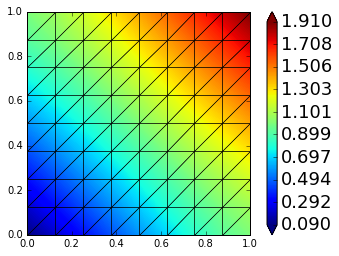

In [9]:
if petsc4py:
    uh.clear()
    res = uh.copy() 

    sol_coeff = uh.as_petsc
    res_coeff = res.as_petsc

    ksp = PETSc.KSP()
    ksp.create(PETSc.COMM_WORLD)
    # use conjugate gradients method
    ksp.setType("cg")
    # and incomplete Cholesky
    ksp.getPC().setType("icc")

    n = 0
    while True:
        scheme(uh, res)
        absF = math.sqrt( res_coeff.dot(res_coeff) )
        print("iterations ("+str(n)+")",absF)
        if absF < 1e-10:
            break
        matrix = scheme.assemble(uh)
        ksp.setOperators(matrix)
        ksp.setFromOptions()
        ksp.solve(res_coeff, res_coeff)
        sol_coeff -= res_coeff
        n += 1
    plot(uh)

At the moment `dune-fem` does not offer the possibility to use an existing user managed `petsc` vector as dof storage for a discrete function. Therefore we can not yet use `petsc`'s non-linear solvers (the `snes` classes) directly. This is work in progress